# Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import time

import numpy as np
import torch
from bnpm import file_helpers, optimization
import sklearn.utils.class_weight
from torch import nn, optim
from tqdm import tqdm
import sklearn.linear_model
import multiprocessing as mp

import roicat.classification.classifier_util as cu
import scipy.sparse
import roicat
import bnpm.h5_handling
from pathlib import Path
import shutil
import warnings
import umap

import matplotlib.pyplot as plt
import matplotlib.offsetbox
import json
import os
import natsort
from roicat import helpers
# from kymatio.torch import Scattering2D
import gc
import functools

2023-06-12 16:10:22.304172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Specify Initial Parameters

In [2]:
directory_data_suite2pSearch = r'/Users/josh/analysis/data/ROICaT/classification/stat_s2p' # Place from which to load suite2p data
directory_save_labelOutputs = r'/Users/josh/analysis/outputs/ROICaT/classification/01_labels' # Place to dump Data object dict, ROINet object dict, Labels, and Parameters dict
testing = True
run_umap = True
filepath_umapModel = ''

In [3]:
directory_save = Path(directory_save_labelOutputs)
directory_save.mkdir(exist_ok=True, parents=True)

In [4]:
pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = test = helpers.find_paths(
    dir_outer=directory_data_suite2pSearch,
    reMatch=pathSuffixToStat,
    depth=4,
)
paths_allOps = test = helpers.find_paths(
    dir_outer=directory_data_suite2pSearch,
    reMatch=pathSuffixToOps,
    depth=4,
)

print(paths_allStat)
print(paths_allOps)

#Import data
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',
    out_height_width=[36, 36],
    type_meanImg='meanImgE',
    verbose=True,
);

['/Users/josh/analysis/data/ROICaT/classification/stat_s2p/stat.npy']
['/Users/josh/analysis/data/ROICaT/classification/stat_s2p/ops.npy']
Starting: Importing FOV images from ops files


/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 1 FOV images.
Completed: Set FOV_images for 1 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 1/1 [00:01<00:00,  1.55s/it]


Imported 1 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 1 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


# Run 2D UMap OR Project onto Previousy Fit UMap for Hand Labeling

In [5]:
# Neural network embedding distances
roinet = roicat.ROInet.ROInet_embedder(
    device=roicat.util.helpers.set_device('cuda:0'),
    dir_networkFiles=r"/Users/josh/analysis/models",
    download_method="check_local_first",
    download_url="https://osf.io/xwzhp/download",
    download_hash="134b170242141c26b0adbd9e0fd80d0e",
    forward_pass_version="head",
    verbose=True,
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    
);

# roicat.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

roinet.generate_latents();

gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

devices available: []
no GPU available. Using CPU.
File already exists locally: /Users/josh/analysis/models/ROInet.zip


/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:191: UserWarning: RH WARNING: unable to get cpu info. Got error: No module named 'cpuinfo'
  warnings.warn(f'RH WARNING: unable to get cpu info. Got error: {e}')
/Users/josh/analysis/github_repos/ROICaT/roicat/util.py:210: UserWarning: RH WARNING: unable to get gpu info. Got error: No module named 'GPUtil'
  warnings.warn(f'RH WARNING: unable to get gpu info. Got error: {e}')


Hash of local file matches provided hash_hex.
Extracting /Users/josh/analysis/models/ROInet.zip to /Users/josh/analysis/models.
Completed zip extraction.
['/Users/josh/analysis/models/ROInet_classification_20220902', '/Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth', '/Users/josh/analysis/models/ROInet_classification_20220902/model.py', '/Users/josh/analysis/models/ROInet_classification_20220902/classifier.pkl', '/Users/josh/analysis/models/ROInet_classification_20220902/params.json', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__', '/Users/josh/analysis/models/ROInet_classification_20220902/__pycache__/model.cpython-39.pyc']
Imported model from /Users/josh/analysis/models/ROInet_classification_20220902/model.py
Loaded params_model from /Users/josh/analysis/models/ROInet_classification_20220902/params.json


/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/josh/opt/anaconda3/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /Users/josh/analysis/models/ROInet_classification_20220902/ConvNext_tiny__1_0_best__simCLR_wPCA.pth
Loaded network onto device cpu
Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader
starting: running data through network


100%|██████████| 613/613 [09:37<00:00,  1.06it/s]


completed: running data through network


Fitting UMAP...
Unspecified filepath_umapModel in params... not saving UMAP to file.
Generating Embeddings...
Embeddings Generated...


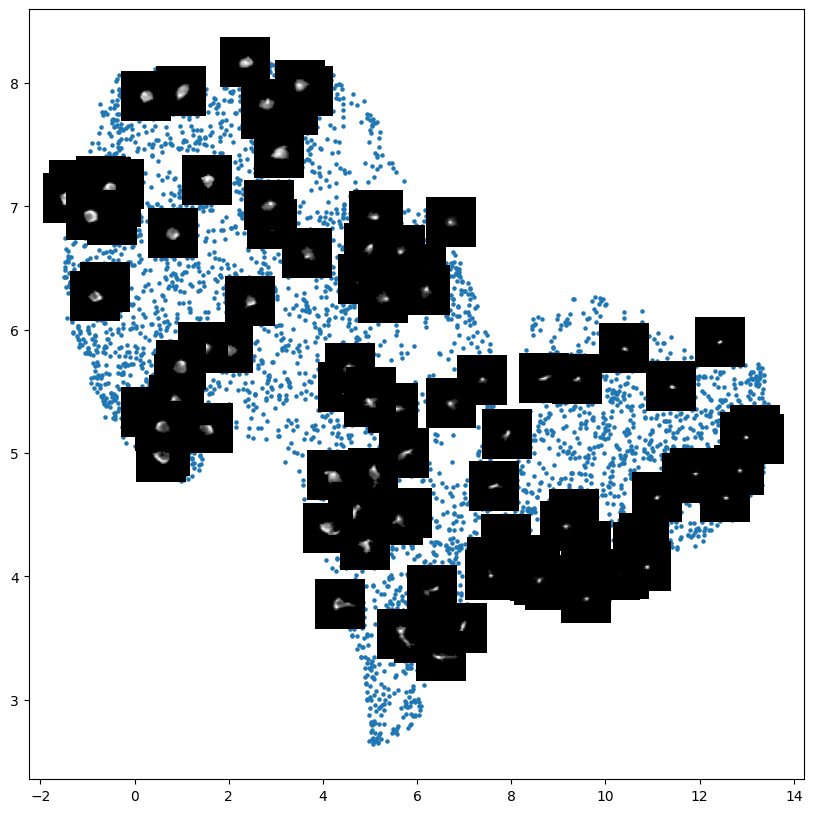

In [7]:
# if run_umap:
#     umap_model = cu.UMAP_Labeler()
#     print('Fitting UMAP...')
#     umap_model.fit(roinet.latents)

#     if filepath_umapModel:
#         raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file
#         # print(f'Saving UMAP to {params["paths"]["filepath_umapModel"]}...')
#         # joblib.dump(umap, params['paths']['filepath_umapModel'])
#     else:
#         print('Unspecified filepath_umapModel in params... not saving UMAP to file.')
# elif filepath_umapModel:
#     raise NotImplementedError('Loading UMAP from file not yet implemented.') # TODO: JZ, Implement loading UMAP from file
#     # print(f'Loading UMAP from {params["paths"]["filepath_umapModel"]}...')
#     # umap = joblib.load(params['paths']['filepath_umapModel'])
# else:
#     raise ValueError(f'run_umap must be True or filepath_umapModel must be specified in params.')

umap_model = cu.UMAP_Labeler()
print('Fitting UMAP...')
umap_model.fit(roinet.latents)
print('Generating Embeddings...')
embeddings = umap_model.transform(roinet.latents)
print('Embeddings Generated...')
%matplotlib inline
umap_model.plot_annotated(data, embeddings)

# TODO: JZ, Add Circling Code for Labeling
if testing:
    num_zeroLabels = np.concatenate(data.ROI_images).shape[0]//2
    num_onesLabels = np.concatenate(data.ROI_images).shape[0] - np.concatenate(data.ROI_images).shape[0]//2
    arr_labels = np.concatenate([np.zeros(num_zeroLabels), np.ones(num_onesLabels)])
else:
    raise NotImplementedError('Saving UMAP to file not yet implemented.') # TODO: JZ, Implement saving UMAP to file

# Save Outputs

In [ ]:
with open(str((Path(directory_save) / 'feature_label_combo.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr={
            'rois': data.ROI_images,
            'latents': roinet.latents,
            'embeddings': embeddings,
            'labels': arr_labels,
        },
        allow_pickle=True,
    )
with open(str((Path(directory_save) / 'pkl_labelingRunInterim.npy').resolve()), 'wb') as f:
    np.save(
        file=f,
        arr=labelingRun_interim,
        allow_pickle=True
    )

print(f'Saving files completed.')